Импортируем необходимые библиотеки.

In [1]:
import pickle
import numpy as np
from sympy import *
import math
from math import copysign as sgn, factorial as fact
from mpmath import besselj as Jn
from sympy.physics.quantum.cg import CG
from scipy.special import gamma, binom, sph_harm as Ynm, gammaincc
from scipy.special import spherical_jn
from scipy import integrate
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Считаем из бинарных файлов сетку интегрирования, положения атомов в молекуле и электронную плотность.

In [2]:
with open("grid.bin", "rb") as file:
    coords = pickle.load(file)
coords.shape

with open("NH2_coords.bin", "rb") as file:
    geometry = pickle.load(file)
    
with open("density.bin", "rb") as file:
    density = pickle.load(file)

Аналогично - суммарный потенциал.

In [3]:
with open("Vtot.bin", "rb") as file:
    Vtot = pickle.load(file)
Vtot=Vtot.reshape(len(Vtot),1)
Vtot.shape

(378000, 1)

Объединим координаты узлов сетки интегрирования и значения потенциала в один массив.

In [ ]:
Vcoord = np.concatenate([Vtot,coords],axis=1)
Vcoord.shape

Зададим размеры сетки интегрирования (см. файл Vxc), для удобства разобьем массив с суммарным потенциалом на блоки, аналогичные файлу Vxc.

In [6]:
N_R=150
N_Theta = 35
N_Phi = 72
Vcoord_norm = Vcoord.reshape(N_R,N_Theta*N_Phi,4)

Зададим массив с весами для численного интегрирования методом трапеций.

In [7]:
weights=[]
h1=h2=1
for j in range (N_Theta):
    if ((j==0) or (j==N_Theta-1)):
        h1=0.5
    else:
        h1=1
    for k in range (N_Phi):
        if ((k==0) or (k==N_Phi-1)):
            h2=0.5
        else:
            h2=1
        weights.append(h1*h2)
weights = np.array(weights)
weights.shape

(2520,)

Зададим функцию расчета коэффициента разложения потенциала по сферическим гармоникам для выбранных $l$ и $m$:
$$ f_{lm}(r_i) = \int\limits_0^{2\pi} d\varphi \int\limits_0^\pi d\theta \sin(\theta)V(r_i,\theta,\varphi)Y_{lm}^*(\theta,\varphi) $$

In [9]:
def V_int(arr,weights,l,m):
    res=0
    angle0=np.pi/36
    integral = arr[:,0]*np.sin(arr[:,2])*np.conj(Ynm(m,l,arr[:,3],arr[:,2]))*weights*angle0*angle0
    res=np.sum(integral)
    return res

Зададим максимальный член разложения потенциала по сферическим гармоникам, создадим массив коэффициентов данного разложения вида: $[r,l,m,f_{lm}]$.

In [10]:
Lmax=12

coeff=[]
for R_block in Vcoord_norm:
    r_line=[]
    for l in range (Lmax+1):
        for m in range(-l,l+1):
            f = V_int(R_block,weights,l,m)
            r_line.append([R_block[0,1],l,m,f])
    coeff.append(r_line)
coeff=np.array(coeff)
coeff.shape

(150, 169, 4)

Возьмем 50 пробных точек, в которых расчитаем значение потенциала, разложенного по сферическим гармоникам, выведем координаты точек с ошибкой больше 10%.

In [11]:
from random import randint

for i in range(50):
    res=0
    c1=randint(0,149)
    c2=randint(0,N_Theta*N_Phi-1)
    for line in coeff[c1]:
        res+=line[3]*Ynm(int(line[2]),int(line[1]),Vcoord_norm[c1,c2,3],Vcoord_norm[c1,c2,2])
    V_prob = Vcoord_norm[c1,c2,0]
    err=abs((np.real(res)-V_prob)/V_prob)*100
    if err>10:
        print(err, ' ', Vcoord_norm[c1,c2])

10.901330282860627   [-1.30945186  0.7         1.48352986  5.75958653]
31.993360080188076   [-0.01746279  9.2         1.65806279  6.19591884]
29.71263725979092   [-7.76194587e-03  1.49000000e+01  8.72664626e-02  5.06145483e+00]
12.048214058366403   [-1.04125953e-02  1.15000000e+01  4.36332313e-01  0.00000000e+00]
30.23081145669147   [-0.19679416  3.1         3.05432619  4.27605667]
21.93010103383565   [-0.22090489  3.1         2.53072742  6.19591884]
31.088237976036908   [-9.41325329e-03  1.13000000e+01  3.05432619e+00  1.83259571e+00]
20.81133238930872   [-0.7402201   1.5         2.18166156  3.66519143]


C:\Users\Konstantin\AppData\Local\Temp\ipykernel_3952\1477664708.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  res+=line[3]*Ynm(int(line[2]),int(line[1]),Vcoord_norm[c1,c2,3],Vcoord_norm[c1,c2,2])


Увеличим сетку интегрирования, сделав шаг по R 0.01 вместо 0.1.

In [14]:
R_approx=np.linspace(0.1,15,1491)
R_val = np.array(coeff[:,0,0], dtype=float)
R_approx = R_approx[~np.isin(R_approx, R_val)]
R_approx.shape

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_1836\3887351211.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  R_val = np.array(coeff[:,0,0], dtype=float)


(1367,)

Зададим функции для интерполяции радиальных членов многочленом Лагранжа: функцию для нахождения индексов в массиве точек, ближайших к заданной, а также функцию для расчета коэффициентов интерполяции
(см. https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BF%D0%BE%D0%BB%D1%8F%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD_%D0%9B%D0%B0%D0%B3%D1%80%D0%B0%D0%BD%D0%B6%D0%B0#:~:text=%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BF%D0%BE%D0%BB%D1%8F%D1%86%D0%B8%D0%BE%CC%81%D0%BD%D0%BD%D1%8B%D0%B9%20%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%CC%81%D0%BD%20%D0%9B%D0%B0%D0%B3%D1%80%D0%B0%CC%81%D0%BD%D0%B6%D0%B0%20%E2%80%94%20%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%20%D0%BC%D0%B8%D0%BD%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9,%D1%82%D0%BE%20%D0%B5%D1%81%D1%82%D1%8C%20%D1%80%D0%B5%D1%88%D0%B0%D1%8E%D1%89%D0%B8%D0%B9%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D1%83%20%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%BF%D0%BE%D0%BB%D1%8F%D1%86%D0%B8%D0%B8).

In [16]:
def find_index(numbers, target):
    diffs = [(i, abs(num - target)) for i, num in enumerate(numbers)]
    sorted_diffs = sorted(diffs, key=lambda x: x[1])
    indices = [pair[0] for pair in sorted_diffs]
    return indices

In [17]:
def Lagrange(R, indices, prop, NumDots):
    res=0
    for i in range(NumDots):
        l_i = 1
        for j in range(NumDots):
            if i!=j:
                mult = (R-(prop[indices[j]][0]))/((prop[indices[i]][0])-(prop[indices[j]][0]))
                l_i*=mult
        res+= (prop[indices[i]][1])*l_i
    return res

Создадим массив коэффициентов искомого многочлена для разных количеств точек интерполяции: от 2 до 10.

In [15]:
y_i=np.zeros([len(R_approx),9])
for l in range(Lmax+1):
    for m in range(-l,l+1):
        y_i_slice=[]
        values= coeff[:,l*l+(l+m),[0,3]]
        for R in R_approx:
            indices = find_index(R_val, R)
            y_line=[]
            for NumDots in range(2,11):
                lagr = Lagrange(R,indices,values,NumDots)
                y_line.append(lagr)
            y_i_slice.append(y_line)
        y_i=y_i+np.array(y_i_slice)

In [16]:
y_i.shape

(1367, 9)

С помощью МНК найдем наилучшее количество точек интерполяции.

In [17]:
res=[]
for n in range(8):
    line=np.sum((y_i[:,n]-y_i[:,n+1])**2)
    res.append(line)

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Text(0.5, 0, 'NumOfDots')

Text(0, 0.5, 'LS')

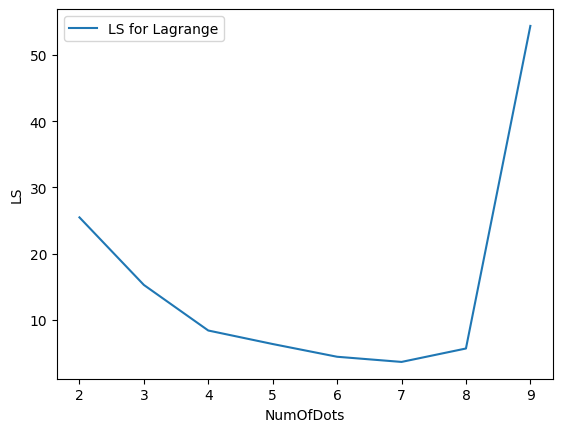

In [19]:
res=np.array(res)
res=np.abs(res)
x=np.arange(2,10,1)
plt.plot(x, res, label='LS for Lagrange')
plt.xlabel('NumOfDots')
plt.ylabel('LS')
plt.legend()
plt.show()

Нарисуем, как выглядит интерполяционный многочлен, и где находятся истинные значения потенциала для заданных значений $l$ и $m$.

Text(0.5, 0, 'R')

Text(0, 0.5, 'V')

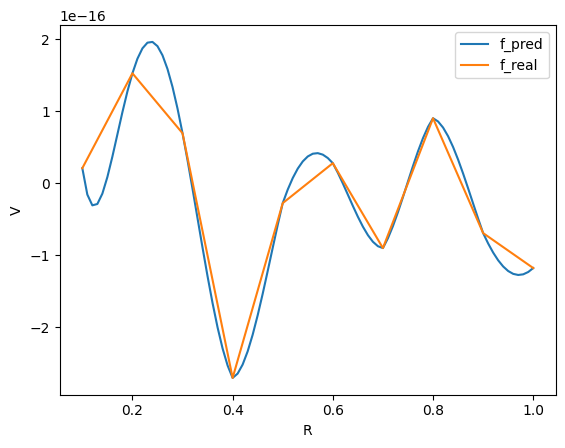

In [21]:
l=2
m=1
values= coeff[:,l*l+(l+m),[0,3]]
r=np.linspace(0.1,1,91)
l_val=[]
for r0 in r:
    indices_r=find_index(R_val,r0)
    l_val.append(Lagrange(r0,indices_r,values,6))
    
l_val=np.array(l_val)
#l_val=np.imag(l_val)
#l_val=np.abs(l_val)
plt.plot(r, l_val, label='f_pred')
#plt.plot(values[:10,0], np.abs(values[:10,1]), label='f_real')
#plt.plot(values[:10,0], np.imag(values[:10,1]), label='f_real')
plt.plot(values[:10,0], values[:10,1], label='f_real')
plt.xlabel('R')
plt.ylabel('V')
plt.legend()
plt.show()

Запишем в текстовый файл данные о разложении потенциала по сферическим гармоникам.\
$\textbf{NB}$: Так как времени было мало, я не успел сделать вывод значений интерполяционного многочлена, поэтому в дальнейшем в коде Георгия расчет велся на исходной сетке интегрирования. По-хорошему, конечно, нужно самостоятельно написать код для расчета параметра анизотропии в новом подходе с учетом новой, более хорошей сетки.

In [19]:
InteractiveShell.ast_node_interactivity = "none"

In [27]:
with open("V_NH2.txt", "w") as file2:
    file2.write("r l m Re(R) Im(R)"+'\n')
    for block_r in coeff:
        for line in block_r:
            if abs(line[3])>1e-10:
                file2.write(str(float(line[0])) + " ")
                for index in range (1,3):
                    file2.write(str(int(line[index])) + " ")
                file2.write(str(re(line[3])) + " ")
                file2.write(str(im(line[3])) + '\n')

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_1836\400755914.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  file2.write(str(float(line[0])) + " ")
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_1836\400755914.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  file2.write(str(int(line[index])) + " ")
